# Проект 1. A/B-тестирование алгоритма рекомендаций постов

В ходе тестирования гипотезы целевой группе (группа 2) был предложен новый алгоритм рекомендации постов. Рекомендательная система для контрольной группы (группа 1) осталась прежней. Эксперимент проходил с 2024-09-27 по 2024-10-03 включительно.

**Метрика успеха:**

В качестве основной метрики успеха выступает **CTR (click-through rate)**, так как она является ключевым показателем пользовательской вовлеченности.

**Основная гипотеза:**

Новый алгоритм во 2-й группе приведет к увеличению CTR.

**Задача:** Проанализировать данные A/B-теста и дать обоснованную рекомендацию о внедрении нового алгоритма.

In [3]:
import pandas as pd
import pandahouse as ph
import hashlib
import swifter
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#параметры подлючения к бд
connection = {'host': 'https://clickhouse.example',
            'database':'database',
            'user':'user',
            'password':'password'
            }

q = """
    SELECT exp_group,
            user_id,
            sum(action = 'like') as likes,
            sum(action = 'view') as views,
            likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) between '2024-09-27' and '2024-10-03' and exp_group in (1,2)
    GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


В ходе анализа обнаружено небольшое различие в размерах групп: 10020 пользователей в контрольной (группа 1) и 9877 в экспериментальной (группа 2). Эта разница, составляющая около 1.43%, может незначительно снизить статистическую мощность теста и сделать результаты более чувствительными к выбросам. Однако, сбалансированность групп в целом хорошая, и ожидается, что это не окажет существенного влияния на достоверность анализа.

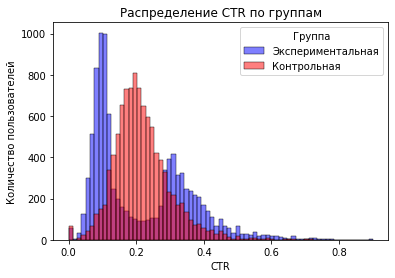

In [10]:
group1_sample = df[df.exp_group == 1]
group2_sample = df[df.exp_group == 2]

# cравнивним подвыборки t-тестом
p_value = stats.ttest_ind(group1_sample['ctr'], group2_sample['ctr'], equal_var=False).pvalue

#посмотрим на распределение ctr в группах
groups = sns.histplot(data = df,
                        x='ctr',
                        hue='exp_group',
                        palette = ['r', 'b'],
                        alpha=0.5,
                        kde=False)

groups.set_title('Распределение CTR по группам')
groups.set_xlabel('CTR')
groups.set_ylabel('Количество пользователей')

plt.legend(title='Группа', labels=['Экспериментальная', 'Контрольная'])
plt.show()


In [17]:
#средние CTR в каждой группе
mean_ctr_group1 = group1_sample['ctr'].mean()
mean_ctr_group2 = group2_sample['ctr'].mean()
difference_percent = (mean_ctr_group2 - mean_ctr_group1) / mean_ctr_group1 * 100

print(f"Средний CTR в контрольной группе: {mean_ctr_group1:.4f}")
print(f"Средний CTR в экспериментальной группе: {mean_ctr_group2:.4f}")
print(f"Разница между средними CTR: {difference_percent:.4f}%")

Средний CTR в контрольной группе: 0.2168
Средний CTR в экспериментальной группе: 0.2161
Разница между средними CTR: -0.3101%


### Анализ результатов t-теста и особенности распределения CTR

Хотя визуально распределения CTR в группах отличаются, t-тест, не выявил статистически значимых различий. Первичный анализ с использованием t-теста не выявил статистически значимых различий в CTR между контрольной (группа 1) и экспериментальной (группа 2) группами. Полученное p-value (0.685) значительно превышает стандартный уровень значимости (0.05), что свидетельствует о том, что мы не можем отвергнуть нулевую гипотезу об отсутствии различий между группами.

### Выводы из анализа средних CTR и распределений

Наблюдается небольшое снижение среднего CTR в экспериментальной группе по сравнению с контрольной. Разница между средними значениями CTR составляет всего -0.3101%, что является относительно небольшой величиной. Визуализация распределений CTR показывает, что:
*   В контрольной группе распределение CTR выглядит близким к нормальному.
*   В экспериментальной группе распределение CTR имеет признаки бимодальности, что указывает на неоднородность пользовательского поведения внутри группы (наличие пользователей с разным характером активности: 

    *   Активные пользователи: Пользователи, у которых много просмотров и, как следствие, более стабильный CTR.
    *   Менее активные пользователи: Пользователи с небольшим количеством просмотров, чей CTR может быть подвержен сильным случайным колебаниям.

**Почему t-тест не обнаружил статистически значимых различий?**

1.  **Малый размер эффекта:** Разница между средними CTR в группах (0.31%) настолько мала, что ее сложно выявить статистическими методами, особенно с учетом имеющейся дисперсии в данных.
2.  **Недостаточная мощность теста:** Возможно, для выявления столь малых различий при имеющейся дисперсии, нам не хватает мощности теста, то есть объема выборки.
3.  **Влияние распределения:** t-тест является параметрическим тестом и опирается на предположение о нормальности распределения данных. Наличие бимодального распределения в экспериментальной группе могло повлиять на результаты t-теста. Бимодальное распределение, как правило, содержит выбросы, которые могут влиять на среднее значение и дисперсию данных.  t-тест чувствителен к таким выбросам, поэтому их наличие может исказить результаты теста и повлиять на корректность полученных выводов.


**В связи с этим, для более точного анализа данных и учета выявленных особенностей распределения, будут предприняты следующие шаги:**

1.  **Сглаживание CTR:**  Для уменьшения влияния выбросов и случайных колебаний в данных, а также для приближения распределения к нормальному, будет проведено сглаживание CTR методом Лапласа с гиперпараметром α=5. Это может помочь выявить более устойчивые различия между группами, если они существуют.
2.  **Непараметрические тесты:** Далее будут применены непараметрические тесты (тест Манна-Уитни), которые не требуют предположения о нормальности распределения и, таким образом, могут быть более подходящими для анализа наших данных.
3. **Пуассоновский бутстреп:** Пуассоновский бутстреп — это метод, который моделирует множественные выборки, перевзвешивая исходные данные с помощью случайных весов из распределения Пуассона, позволяя оценивать распределение общих метрик, таких как CTR, без предположений о нормальности. 
3. **Бакетное преобразование:** Для дополнительной проверки, будет проведено бакетное преобразование CTR, так как это может также сгладить выбросы.
4.  **Оценка результатов:**  На последнем этапе будет проведено сравнение результатов, полученные различными методами, чтобы сделать обоснованный вывод о наличии или отсутствии различий между группами и дать рекомендации по внедрению нового алгоритма.

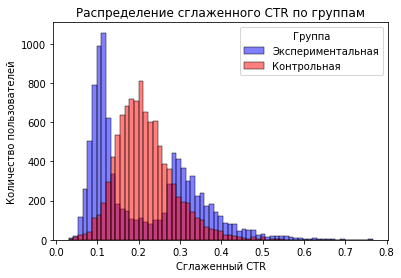

In [18]:
#сглаженный ctr: когда просмотров много, сгалженный ctr будет почти равен ctr пользователя, когда просмотров мало - общегрупповому
def get_smothed_ctr(likes, views, global_ctr, alpha):
    smothed_ctr = (likes + alpha * global_ctr) / (views + alpha)
    return smothed_ctr

#общегрупповой ctr
global_ctr1 = df[df.exp_group == 1].likes.sum() / df[df.exp_group ==1].views.sum()
global_ctr2 = df[df.exp_group == 2].likes.sum() / df[df.exp_group ==2].views.sum()

# создаю копию group1 и group2 из df, которая содержит только строки, где exp_group равен 1/2
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()


group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr1, 5), axis=1)
    
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr2,5), axis=1)


combined_df = pd.concat([group1, group2])

#посмотрим на распределение ctr после сглаживания
groups = sns.histplot(data=combined_df,
                     x='smothed_ctr',
                     hue='exp_group',
                     palette=['r', 'b'],
                     alpha=0.5,
                     kde=False)

groups.set_title('Распределение сглаженного CTR по группам')
groups.set_xlabel('Сглаженный CTR')
groups.set_ylabel('Количество пользователей')

plt.legend(title='Группа', labels=['Экспериментальная', 'Контрольная'])
plt.show()


In [19]:
#t-test после сгалживания ctr
stats.ttest_ind(group1['smothed_ctr'], group2['smothed_ctr'], equal_var = False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

In [20]:
#средние CTR в каждой группе
mean_smothed_ctr_group1 = group1['smothed_ctr'].mean()
mean_smothed_ctr_group2 = group2['smothed_ctr'].mean()
difference_percent = (mean_smothed_ctr_group2 - mean_smothed_ctr_group1) / mean_smothed_ctr_group1 * 100

print(f"Средний сглаженный CTR в контрольной группе: {mean_smothed_ctr_group1:.4f}")
print(f"Средний сглаженный CTR в экспериментальной группе: {mean_smothed_ctr_group2:.4f}")
print(f"Разница между ср. сглаженными CTR: {difference_percent:.4f}%")

Средний сглаженный CTR в контрольной группе: 0.2153
Средний сглаженный CTR в экспериментальной группе: 0.2125
Разница между ср. сглаженными CTR: -1.2875%


### Анализ результатов t-теста на сглаженном CTR

После применения сглаживания Лапласа к CTR, был повторно проведен t-тест для сравнения средних значений сглаженного CTR между контрольной (группа 1) и экспериментальной (группа 2) группами. Результаты t-теста показали, что различия в сглаженном CTR между группами не являются статистически значимыми (statistic=1.946, p-value=0.0516). Сглаживание привело к увеличению разницы в средних CTR между группами, по сравнению с исходными данными (-1.2875%). 


Полученное p-value (0.0516) немного превышает стандартный уровень значимости (0.05), поэтому мы не можем отвергнуть нулевую гипотезу об отсутствии различий между группами. Однако, поскольку p-value близко к границе значимости, мы не можем однозначно утверждать об отсутствии различий. Этот результат может быть неоднозначным, что указывает на необходимость дальнейшего изучения.

**Факторы, которые могут влиять на результаты:**

1.  **Размер эффекта:** Эффект от нового алгоритма (если он есть) слишком мал, чтобы быть обнаруженным с текущим размером выборки и дисперсией.
2.  **Выбросы и ненормальность распределения:** Несмотря на применение сглаживания, визуально распределение сглаженного CTR в экспериментальной группе (группа 2) все еще не похоже на нормальное и имеет признаки бимодальности. t-тест чувствителен к ненормальности распределения и к выбросам. Кроме того, стоит учесть, что количество данных в группах различается. 
3.  **Разница в размерах групп:** Различие в размерах групп (10020 в контрольной и 9877 в экспериментальной) также может внести небольшую погрешность в результаты t-теста.

**Дальнейшие шаги для более глубокого анализа:**

Учитывая неоднозначность результатов t-теста и его потенциальные ограничения, будет продолжено исследование данных с использованием других методов: 

2. **Непараметрические тесты** 
3. **Пуассоновский бутстреп** 
4. **Бакетное преобразование** 
5. **Оценка результатов** 

In [15]:
#тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr,alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

Тест Манна-Уитни выявил статистически значимые различия между распределениями CTR в контрольной и экспериментальной группах. Полученное p-value (4.63e-45) крайне мало, что свидетельствует о том, что вероятность получить наблюдаемые различия, если бы на самом деле различий не было, чрезвычайно низка.

В отличие от t-теста, который проверяет равенство средних, тест Манна-Уитни чувствителен к различиям в распределениях между группами. Полученные результаты говорят о том, что распределения CTR в контрольной и экспериментальной группах имеют существенные отличия, которые не были выявлены t-тестом. 


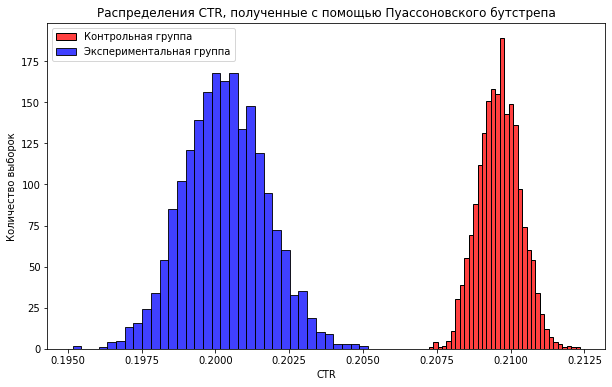

In [22]:
#Пуассоновский бутстреп

def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    
    """
    Проводит Пуассоновский бутстреп для оценки распределения CTR.

    Args:
        likes1 (np.ndarray): Массив лайков для контрольной группы.
        views1 (np.ndarray): Массив просмотров для контрольной группы.
        likes2 (np.ndarray): Массив лайков для экспериментальной группы.
        views2 (np.ndarray): Массив просмотров для экспериментальной группы.
        n_bootstrap (int, optional): Количество бутстреп-выборок. Defaults to 2000.

    Returns:
        tuple: Два массива, представляющих распределение CTR для контрольной и экспериментальной групп.
    """
    
    #генерируем случайные веса из распределения Пуассона для контрольной группы
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    
    #генерируем случайные веса из распределения Пуассона для экспериментальной группы
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    #рассчитываем средний CTR для каждой бутстреп-выборки в контрольной группе
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    #рассчитываем средний CTR для каждой бутстреп-выборки в экспериментальной группе
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

#извлекаем данные о лайках и просмотрах для обеих групп
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

#проводим Пуассоновский бутстреп для получения распределений CTR
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

#строим гистограмму 
plt.figure(figsize=(10, 6))
sns.histplot(ctr1, color='red', label='Контрольная группа')
sns.histplot(ctr2, color='blue', label='Экспериментальная группа')

plt.title('Распределения CTR, полученные с помощью Пуассоновского бутстрепа')
plt.xlabel('CTR')
plt.ylabel('Количество выборок')
plt.legend()
plt.show()

In [24]:
#разница между CTR в экспериментальной и контрольной группах для каждой бутстреп-выборки
differences = ctr2 - ctr1

#наблюдаемая разница между средними CTR в исходных данных
observed_difference = np.mean(df[df.exp_group == 2].likes / df[df.exp_group == 2].views) - np.mean(df[df.exp_group == 1].likes / df[df.exp_group == 1].views)

#рассчитываем p-value как долю бутстреп-выборок, где разница CTR больше или равна наблюдаемой разнице
p_value = np.mean(differences >= observed_difference)

print(f"P-value: {p_value}")

P-value: 0.0


### Результаты Пуассоновского бутстрепа

Пуассоновский бутстреп подтвердил, что существует статистически значимая разница между группами, и эта разница указывает на снижение CTR в экспериментальной группе.

*   **Распределение глобальных CTR:** Гистограммы, построенные на основе результатов бутстрепа, показывают распределения глобальных CTR для каждой группы (контрольной и экспериментальной). Распределения глобальных CTR, полученные после бутстрепа, не пересекаются. При этом значение глобального CTR для контрольной группы (группа 1) больше, чем для экспериментальной группы (группа 2). Важно отметить, что оба распределения имеют куполообразную форму, напоминающую нормальное распределение.
*   **Гистограмма разницы глобальных CTR:** Гистограмма разницы между глобальными CTR (группа 2 минус группа 1) показывает, что глобальный CTR экспериментальной группы в большинстве случаев меньше, чем глобальный CTR контрольной группы.
*   **p-value:** p-value, рассчитанный как доля бутстреп-выборок, где разница CTR больше или равна наблюдаемой разнице, равен 0.

**Интерпретация:**

Полученные результаты бутстрепа свидетельствуют о том, что есть статистически значимые различия между глобальными CTR в контрольной и экспериментальной группах. Поскольку p-value равен 0, мы можем отвергнуть нулевую гипотезу об отсутствии различий между группами.

При этом, что важно, результаты бутстрепа показывают, что средний CTR в экспериментальной группе (группа 2) ниже, чем в контрольной группе (группа 1). Это означает, что новый алгоритм, вопреки первоначальным ожиданиям, не привел к улучшению, а скорее к снижению CTR.


**Дальнейшие шаги для более глубокого анализа:**

4. **Бакетное преобразование** 
5. **Оценка результатов** 

In [32]:
#t-тест и тест Манна-Уитни поверх бакетного преобразования

#запрос к бд для бакетного преобразовнаия

q1 = """
        SELECT exp_group, bucket,
            sum(likes)/sum(views) as bucket_ctr, -- Рассчитываем средний CTR для каждого бакета
            quantileExact(0.9)(ctr) as ctr9 -- Рассчитываем 90-й перцентиль CTR для каждого бакета
        FROM (SELECT exp_group, 
                xxHash64(user_id)%50 as bucket, -- Распределяем пользователей по 50 бакетам на основе их user_id
                user_id,
                sum(action = 'like') as likes,
                sum(action = 'view') as views,
                likes/views as ctr
            FROM {db}.feed_actions 
            WHERE toDate(time) between '2024-09-27' and '2024-10-03'
                and exp_group in (1,2)
            GROUP BY exp_group, bucket, user_id)
        GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q1, connection=connection)

#тест Манна-Уитни для сравнения CTR между группами на уровне бакетов
stats.mannwhitneyu(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [33]:
# t-тест для сравнения CTR между группами на уровне бакетов
stats.ttest_ind(df1[df1.exp_group == 1].bucket_ctr, 
                   df1[df1.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

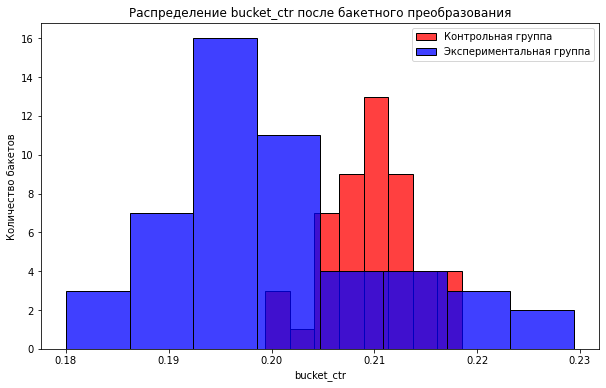

In [34]:
#смотрим гистограммы
plt.figure(figsize=(10, 6)) 
sns.histplot(df1[df1.exp_group == 1].bucket_ctr, color='red', label='Контрольная группа')
sns.histplot(df1[df1.exp_group == 2].bucket_ctr, color='blue', label='Экспериментальная группа')

plt.title('Распределение bucket_ctr после бакетного преобразования')
plt.xlabel('bucket_ctr')
plt.ylabel('Количество бакетов')
plt.legend()  
plt.show()

### Выводы по результатам бакетного преобразования

После проведения бакетного преобразования данных, мы получили следующие результаты:

*   **Гистограмма распределения bucket_ctr:** Гистограммы распределения среднего CTR по бакетам (bucket_ctr) показывают, что контрольная группа (группа 1) имеет тенденцию к более высоким значениям `bucket_ctr`, чем экспериментальная группа (группа 2).
*   **Тест Манна-Уитни:** Тест Манна-Уитни, проведенный на `bucket_ctr`, подтвердил наличие статистически значимых различий между группами. Это указывает на то, что распределения CTR между группами различаются даже после бакетного преобразования.
*   **T-тест:** Повторный t-тест, проведенный на `bucket_ctr`, также показал наличие статистически значимых различий между группами, что согласуется с результатами теста Манна-Уитни.
    

**Интерпретация:**

Результаты бакетного преобразования подтверждают выводы, полученные ранее с помощью Пуассоновского бутстрепа и непараметрического теста на исходных данных. Использование бакетного преобразования позволило дополнительно сгладить данные и убедиться в надежности полученных результатов.


## Анализ результатов A/B теста нового алгоритма

### 1. Цель эксперимента

Проверка эффективности нового алгоритма рекомендации контента на метрику CTR.

### 2. Сравнение данных

Были применены несколько статистических методов для сравнения контрольной (группа 1) и экспериментальной (группа 2) групп:

1.  **t-тест:** Не выявил значимых различий между группами из-за бимодального распределения CTR во второй группе.  t-тест чувствителен к отклонениям от нормального распределения.

2.  **Сглаживание CTR:** Применение сглаживания помогло уменьшить влияние выбросов и бимодальности в данных группы 2, сделав данные более подходящими для t-теста.  Однако, результат сглаженного t-теста остался неоднозначным: p-value выше стандартного уровня значимости (0.05), но близко к нему.

3.  **Непараметрический тест Манна-Уитни:** Показал статистически значимое различие между группами.  Тест Манна-Уитни более устойчив к ненормальным распределениям, что позволило выявить различия, которые t-тест пропустил.

4.  **Пуассоновский бутстреп:** Подтвердил наличие статистически значимых различий между группами. Гистограммы разницы CTR смещены в сторону отрицательных значений, что указывает на снижение CTR в экспериментальной группе.

5.  **Бакетное преобразование + t-тест и Манна-Уитни:**  После бакетного преобразования, которое дополнительно сгладило данные,  оба теста (Манна-Уитни и t-тест) снова показали статистически значимые различия между группами.


### 3. Потенциальные причины снижения CTR

Некоторые потенциальные причины снижения CTR в экспериментальной группе:

*   **Неверная оценка предпочтений пользователя:** Алгоритм может не учитывать недавнюю активность пользователя или игнорировать важные факторы.
*   **Ошибки в реализации алгоритма:** В процессе реализации нового алгоритма могли быть допущены ошибки, повлиявшие на его корректную работу.

**Примеры возможных проблем с алгоритмами:**

**Алгоритм "Показываем пользователю посты, наиболее похожие на те, которые он лайкал":**

1.  **Слишком узкая ниша:**  Пользователь, лайкающий только котиков, получает только котиков, игнорируя другой потенциально интересный контент.
2.  **Новые пользователи:**  Новым пользователям без лайков может рекомендоваться случайный контент.

**Алгоритм "Показываем пользователю посты, которые лайкали похожие на него пользователи":**

1.  **Неправильная оценка схожести пользователей:** Алгоритм может некорректно определять схожесть пользователей.


### 4. Решение о выкатке

Все проведенные тесты показали снижение ctr во второй группе, что может говорить о недоработках в алгоритме. Это может привести к снижению дохода и дальнейшему ухудшению показателей вовлеченности. Кроме того, новый алгоритм может переобучиться на данных стартовой группы и плохо работать на новой аудитории. Необходимо также проверить достаточность и репрезентативность размера выборки.

Учитывая эти факторы, **рекомендуется отложить выкатку алгоритма на всех пользователей**. Необходимо продолжить анализ данных, выявить причины, по которым введение нового алгоритма привело к увеличению CTR для части пользователей экспериментальной группы. Выяснить, почему CTR снизился для части пользователей экспирементальной группы. Необходимо доработать алгоритм, провести тест на большей выборке. После выкатки необходимо постоянно мониторить эффективность и вносить коррективы.

**Важно:** В контексте метрики CTR – выкатывать не нужно. Однако, если рассмотреть другую глобальную метрику компании (например, доход), то может оказаться, что алгоритм существенно повысил CTR у определенной группы пользователей, приносящей значительный доход. В этом случае целевая метрика должна быть не средний CTR, а, например, квантиль (например, 90-й перцентиль) CTR, который отражает влияние на высокодоходную группу пользователей.